In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from glob import glob
from subprocess import check_call, check_output
import textwrap

import pandas as pd

import oae_smyle
import project

In [3]:
df_caseinfo = oae_smyle.get_caseinfo(attempt="001")
assert all(df_caseinfo.build)
df_caseinfo

,build,submitted,running,run,archive,error,yr_per_day
case,,,,,,,
smyle.oae-map.North_Atlantic_basin.000.1999-04-01.001,True,True,True,True,True,False,55.91
smyle.oae-map.North_Atlantic_basin.000.1999-07-01.001,True,True,True,True,True,False,56.79
smyle.oae-map.North_Atlantic_basin.000.1999-10-01.001,True,True,True,True,True,False,55.55
smyle.oae-map.North_Atlantic_basin.001.1999-04-01.001,True,True,True,True,True,False,55.20
smyle.oae-map.North_Atlantic_basin.001.1999-07-01.001,True,True,True,True,True,False,55.57
...,...,...,...,...,...,...,...
smyle.oae-map.Southern_Ocean.035.1999-10-01.001,True,True,True,False,False,False,NaN
smyle.oae-map.Southern_Ocean.036.1999-10-01.001,True,True,True,True,True,False,59.78
smyle.oae-map.Southern_Ocean.037.1999-10-01.001,True,True,True,True,True,False,60.00


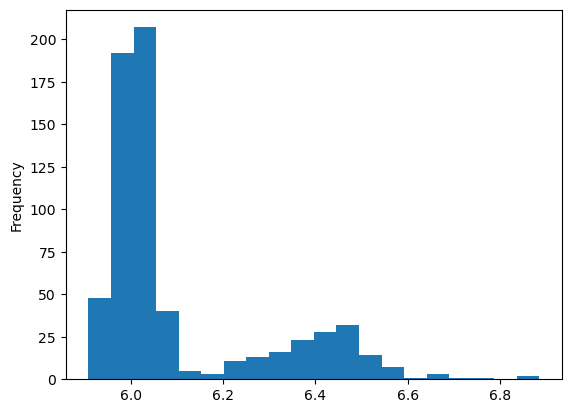

In [4]:
if any(df_caseinfo.loc[df_caseinfo.run]):
    wallclock = 15 / df_caseinfo.loc[(df_caseinfo.run)].yr_per_day * 24
    wallclock.plot.hist(bins=20)

In [5]:
df = pd.read_csv("oae-simulations.csv", index_col=("polygon", "basin", "start_date")).drop(columns=["index", "rmse"])

files = []
for row in df.iterrows():
    p = f"{row[0][0]:03d}"
    b = row[0][1]
    d = row[0][2].replace("0347", "1999")
    file = f"{project.dir_data}/alk-forcing/OAE-Efficiency-Map/alk-forcing-{b}.{p}-{d}.nc"
    assert os.path.exists(file), file
    files.append(file)
    
df["file"] = files
df

,,,polygon_id,file
polygon,basin,start_date,,
0,North_Atlantic_basin,0347-04,0,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...
1,North_Atlantic_basin,0347-04,1,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...
2,North_Atlantic_basin,0347-04,2,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...
3,North_Atlantic_basin,0347-04,3,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...
4,North_Atlantic_basin,0347-04,4,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...
...,...,...,...,...
35,Southern_Ocean,0347-10,685,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...
36,Southern_Ocean,0347-10,686,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...
37,Southern_Ocean,0347-10,687,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...


In [32]:
# smyle.oae-map.North_Atlantic_basin.037.1999-04-01.001
df = df.loc[[(37, "North_Atlantic_basin", "0347-04")]]
df

,,,polygon_id,file
polygon,basin,start_date,,
37,North_Atlantic_basin,0347-04,37,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...


In [33]:
clobber = True
n_run_cases = 1 #738
attempt = "001"

os.makedirs("case-info", exist_ok=True)
os.makedirs("case-info/build-in", exist_ok=True)
os.makedirs("case-info/build-out", exist_ok=True)

def submission_script(case, alk_forcing_file, refdate):
    header = textwrap.dedent(
        f"""\
    #!/bin/bash
    #SBATCH -J build.{case}
    #SBATCH -A {project.account}
    #SBATCH -e case-info/build-out/{case}-%J.out
    #SBATCH -o case-info/build-out/{case}-%J.out
    #SBATCH --time=01:00:00
    #SBATCH --mem=12GB
    #SBATCH --qos=shared
    #SBATCH --nodes=1
    #SBATCH --ntasks=1
    #SBATCH --constraint=cpu

    module purge
    module restore
    module load conda
    conda activate cworthy
    
    python oae_smyle.py --case {case} --alk-forcing-file {alk_forcing_file} --refdate {refdate}

    """
    )
    
    build_script = f"case-info/build-in/{case}.build"
    with open(build_script, "w") as fid:
        fid.write(header)
    
    return build_script


build_scripts = []
for row in df.iterrows():    
    polygon_ndx = f"{row[0][0]:03d}"
    basin = row[0][1]
    refdate = f"{row[0][2]}-01"
    alk_forcing_file = row[1]["file"]
    case = f"smyle.oae-map.{basin}.{polygon_ndx}.{refdate.replace('0347', '1999')}.{attempt}"

    
    built = df_caseinfo.loc[case].build if case in df_caseinfo.index else False
    if built and not clobber:
        continue
    
    print(f"building {case}")        
    build_script = submission_script(case, alk_forcing_file, refdate)
    
    check_call(["sbatch", build_script])
    
    with open("case-info/case-info.built", "a") as fid:
        fid.write(f"{row[0][0]},{row[0][1]},{row[0][2]}\n")
        
    build_scripts.append(build_scripts)   
    if len(build_scripts) == n_run_cases:
        break

building smyle.oae-map.North_Atlantic_basin.037.1999-04-01.001
Submitted batch job 30478474


In [34]:
df_caseinfo = oae_smyle.get_caseinfo(attempt="001")
df_caseinfo

,build,submitted,running,run,archive,error,yr_per_day
case,,,,,,,
smyle.oae-map.North_Atlantic_basin.000.1999-04-01.001,True,True,True,True,True,False,55.91
smyle.oae-map.North_Atlantic_basin.000.1999-07-01.001,True,True,True,True,True,False,56.79
smyle.oae-map.North_Atlantic_basin.000.1999-10-01.001,True,True,True,True,True,False,55.55
smyle.oae-map.North_Atlantic_basin.001.1999-04-01.001,True,True,True,True,True,False,55.20
smyle.oae-map.North_Atlantic_basin.001.1999-07-01.001,True,True,True,True,True,False,55.57
...,...,...,...,...,...,...,...
smyle.oae-map.Southern_Ocean.035.1999-10-01.001,True,True,True,False,False,False,NaN
smyle.oae-map.Southern_Ocean.036.1999-10-01.001,True,True,True,True,True,False,59.78
smyle.oae-map.Southern_Ocean.037.1999-10-01.001,True,True,True,True,True,False,60.00


In [12]:
#cases = df_caseinfo.loc[(df_caseinfo.error) & (df_caseinfo.build) & (~df_caseinfo.run)].index.to_list()
#cases

['smyle.oae-map.North_Pacific_basin.188.1999-10-01.001',
 'smyle.oae-map.South.003.1999-10-01.001',
 'smyle.oae-map.South.004.1999-10-01.001',
 'smyle.oae-map.South.006.1999-10-01.001',
 'smyle.oae-map.South.007.1999-10-01.001',
 'smyle.oae-map.South.008.1999-10-01.001',
 'smyle.oae-map.South.009.1999-10-01.001',
 'smyle.oae-map.South.272.1999-10-01.001',
 'smyle.oae-map.South.273.1999-10-01.001',
 'smyle.oae-map.South.274.1999-10-01.001',
 'smyle.oae-map.South.275.1999-10-01.001',
 'smyle.oae-map.South.276.1999-10-01.001',
 'smyle.oae-map.South.277.1999-10-01.001',
 'smyle.oae-map.South.278.1999-10-01.001',
 'smyle.oae-map.South.279.1999-10-01.001',
 'smyle.oae-map.South.280.1999-10-01.001',
 'smyle.oae-map.South.281.1999-10-01.001',
 'smyle.oae-map.South.282.1999-10-01.001',
 'smyle.oae-map.South.283.1999-10-01.001',
 'smyle.oae-map.South.284.1999-10-01.001',
 'smyle.oae-map.South.285.1999-10-01.001',
 'smyle.oae-map.South.286.1999-10-01.001',
 'smyle.oae-map.South.287.1999-10-01.001

In [14]:
for case in cases:
    log_file = sorted(glob(f"{project.dir_scratch}/{case}/run/cesm.log.????????.??????-??????"))[-1]
    with open(log_file, "r") as fid:
        lines = fid.readlines()
    marbl_error = any(["MARBL ERROR" in l for l in lines])
    print(f"{case}: MARBL Error: {marbl_error}")

smyle.oae-map.North_Pacific_basin.188.1999-10-01.001: MARBL Error: True
smyle.oae-map.South.003.1999-10-01.001: MARBL Error: True
smyle.oae-map.South.004.1999-10-01.001: MARBL Error: True
smyle.oae-map.South.006.1999-10-01.001: MARBL Error: True
smyle.oae-map.South.007.1999-10-01.001: MARBL Error: True
smyle.oae-map.South.008.1999-10-01.001: MARBL Error: True
smyle.oae-map.South.009.1999-10-01.001: MARBL Error: True
smyle.oae-map.South.272.1999-10-01.001: MARBL Error: True
smyle.oae-map.South.273.1999-10-01.001: MARBL Error: True
smyle.oae-map.South.274.1999-10-01.001: MARBL Error: True
smyle.oae-map.South.275.1999-10-01.001: MARBL Error: True
smyle.oae-map.South.276.1999-10-01.001: MARBL Error: True
smyle.oae-map.South.277.1999-10-01.001: MARBL Error: True
smyle.oae-map.South.278.1999-10-01.001: MARBL Error: True
smyle.oae-map.South.279.1999-10-01.001: MARBL Error: True
smyle.oae-map.South.280.1999-10-01.001: MARBL Error: True
smyle.oae-map.South.281.1999-10-01.001: MARBL Error: True


In [24]:
#cases = df_caseinfo.loc[~(df_caseinfo.error) & (df_caseinfo.build) & (~df_caseinfo.run)].index.to_list()
#cases

cases = df_caseinfo.loc[
    (df_caseinfo.error) & 
    (df_caseinfo.build) & 
    (df_caseinfo.running) & 
    (df_caseinfo.index != "smyle.oae-map.South.003.1999-10-01.001")].index.to_list()
cases

['smyle.oae-map.North_Pacific_basin.188.1999-10-01.001',
 'smyle.oae-map.South.004.1999-10-01.001',
 'smyle.oae-map.South.006.1999-10-01.001',
 'smyle.oae-map.South.007.1999-10-01.001',
 'smyle.oae-map.South.008.1999-10-01.001',
 'smyle.oae-map.South.009.1999-10-01.001',
 'smyle.oae-map.South.272.1999-10-01.001',
 'smyle.oae-map.South.273.1999-10-01.001',
 'smyle.oae-map.South.274.1999-10-01.001',
 'smyle.oae-map.South.275.1999-10-01.001',
 'smyle.oae-map.South.276.1999-10-01.001',
 'smyle.oae-map.South.277.1999-10-01.001',
 'smyle.oae-map.South.278.1999-10-01.001',
 'smyle.oae-map.South.279.1999-10-01.001',
 'smyle.oae-map.South.280.1999-10-01.001',
 'smyle.oae-map.South.281.1999-10-01.001',
 'smyle.oae-map.South.282.1999-10-01.001',
 'smyle.oae-map.South.283.1999-10-01.001',
 'smyle.oae-map.South.284.1999-10-01.001',
 'smyle.oae-map.South.285.1999-10-01.001',
 'smyle.oae-map.South.286.1999-10-01.001',
 'smyle.oae-map.South.287.1999-10-01.001',
 'smyle.oae-map.South.288.1999-10-01.001

In [38]:
cases = df_caseinfo.loc[
    (~df_caseinfo.error) & 
    (~df_caseinfo.archive)].index.to_list()


cases

['smyle.oae-map.North_Atlantic_basin.028.1999-10-01.001',
 'smyle.oae-map.North_Atlantic_basin.037.1999-04-01.001',
 'smyle.oae-map.North_Atlantic_basin.040.1999-10-01.001',
 'smyle.oae-map.North_Atlantic_basin.091.1999-04-01.001',
 'smyle.oae-map.North_Atlantic_basin.106.1999-04-01.001',
 'smyle.oae-map.North_Atlantic_basin.120.1999-10-01.001',
 'smyle.oae-map.North_Atlantic_basin.124.1999-04-01.001',
 'smyle.oae-map.North_Atlantic_basin.135.1999-04-01.001',
 'smyle.oae-map.North_Atlantic_basin.144.1999-04-01.001',
 'smyle.oae-map.North_Atlantic_basin.145.1999-10-01.001',
 'smyle.oae-map.North_Pacific_basin.010.1999-10-01.001',
 'smyle.oae-map.North_Pacific_basin.011.1999-10-01.001',
 'smyle.oae-map.North_Pacific_basin.016.1999-10-01.001',
 'smyle.oae-map.North_Pacific_basin.022.1999-10-01.001',
 'smyle.oae-map.North_Pacific_basin.023.1999-10-01.001',
 'smyle.oae-map.North_Pacific_basin.031.1999-10-01.001',
 'smyle.oae-map.North_Pacific_basin.038.1999-10-01.001',
 'smyle.oae-map.North

In [50]:

cases = [
    'smyle.oae-map.South.162.1999-10-01.001'
]
cases    

['smyle.oae-map.South.162.1999-10-01.001']

In [51]:
os.makedirs("case-info/submit-out", exist_ok=True)

n_simult = 10
header = textwrap.dedent("""#!/bin/bash
set -e

module load python

i=0
pids=()
"""
)

script = [header]
submitted = []
n_sub = 0
for n, case in enumerate(cases):
    script.append(textwrap.dedent(
        f"""
        cd {project.dir_caseroot_root}/{case}
        ./xmlchange JOB_WALLCLOCK_TIME=10:00:00
        ./case.submit &> {project.scriptroot}/case-info/submit-out/{case}.submit &
        
        pids[${{i}}]=$!
        i=$(($i+1))
        
        """
    ))
    
    if (len(script) - 1 == n_simult) or n + 1 == len(cases):
        script.append(textwrap.dedent(
        """        
        for pid in ${pids[*]}; do
            echo "waiting on ${pid}"
            wait $pid
        done
        """
        ))
        with open("case-info/batch.case.submit", "w") as fid:
            fid.writelines(script)
        n_sub += len(script) - 1
        
        check_call("bash batch.case.submit > out", shell=True, cwd="case-info")
        script = [header]

In [ ]:
df_caseinfo[df_caseinfo.running]